## Plots for Barcharts

#### Content
[Coding Productivity Plots](#codeprod)  
[Performance Plots Connected Components](#perf_cc)  
[Performance Plots N-Body](#perf_nbody)   
[Python 3.14 no GIL tests](#python)  


##### Packages and main formatting parameters

In [1]:
# executed in conda environment 'plotting' ./conda_envs/plotting

# packages and overall options
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.lines as mlines
import glob
import json
import sys
import math

bol_paper = True

if bol_paper:
    sns.set(style='white', font='serif', font_scale=1.5)
    # fontsize for annotation
    font_size = 14
    fig_width = 9
    fig_height = 4.5
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 4
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True   
    # out path
    out_folder = ''
    legend_anchor=1.2
else:
    sns.set(style='white', font='sans serif', font_scale=1.3)
    # fontsize for annotation
    font_size = 14
    # figur width and height
    fig_width = 10
    fig_height = 4
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    # out path
    out_folder = 'presentations'
    legend_anchor=1.2

# colors
# custom_palette = sns.color_palette('colorblind')
# we use the IBM color design which looks ok for all:https://forum.shotcut.org/t/palette-for-colour-blindness/32219
ibm_colors_hex = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

import matplotlib.colors as mcolors
# Function to lighten colors
def lighten_color(hex_color, factor=0.25):
    """Lightens the given color by blending it with white."""
    rgb = mcolors.hex2color(hex_color)  # Convert to RGB (0-1 range)
    light_rgb = [(1 - factor) * c + factor for c in rgb]  # Blend with white
    return mcolors.to_hex(light_rgb)

# Generate lightened versions of IBM colors
light_ibm_colors_hex = [lighten_color(color, factor=0.25) for color in ibm_colors_hex]

# Add three shades of grey
grey_shades = ['#D3D3D3', '#A9A9A9', '#696969']

# Combine into an extended color palette
extended_colors = ibm_colors_hex + grey_shades + light_ibm_colors_hex

custom_palette = sns.color_palette(extended_colors)

# annotation color on columns
annotate_color='black'


##### Helper functions

In [2]:
def format_with_decimals(value, tick_number):
    return f'{value:.1f}'

# # general methods
# def format_thousands_separator(x, digits=0):
#     # x are the labels (str), if convertible to float its fine.
#     try:
#         if digits == 0:
#             return '{:,.0f}'.format(int(round(float(x),0))).replace(',', "'")
#         else:
#             return '{:,.{}f}'.format(float(x), digits).replace(',', "'")
#     except ValueError:
#         return x

def format_thousands_separator(x, digits=0):
    try:
        num = float(x)

        if num.is_integer():
            return '{:,.0f}'.format(num).replace(',', "'")
        else:
            return '{:,.{d}f}'.format(num, d=digits).replace(',', "'")
    except (ValueError, TypeError):
        return str(x)

def formatter(ax, rotation=None):
    # Format the y-axis ticks
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format_thousands_separator(x, 1)))
    
    ax.tick_params(axis='both', width=0.8)

    if rotation is not None:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', rotation_mode='anchor')

    # Format legend text (if any)
    if ax.get_legend() is not None:
        for label in ax.get_legend().get_texts():
            label.set_text(format_thousands_separator(label.get_text(), 1))  

def make_grid(ax, plt, ygrid=True, xgrid=False):
    ax.yaxis.grid(ygrid)  # Enable the grid
    ax.xaxis.grid(xgrid)  # Enable the grid
    plt.setp(ax.get_ygridlines(), 'linestyle', '-')  # Set grid line style
    plt.setp(ax.get_ygridlines(), 'linewidth', 0.5)  # Set grid line width
    plt.setp(ax.get_ygridlines(), 'color', 'gray', 'alpha', 0.5)  # Set grid line color
    
    # Enhance grid visibility beneath the bars
    ax.set_axisbelow(True)    
    
    # Customize the box line width
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

    # Customize tick parameters
    ax.tick_params(axis='both', width=0.5, length=3)

def annotater(ax, plt, annotation_rotated = False, ylim = None):
    
    rot = 90 if annotation_rotated else 0

    # factor for annotated distance
    anotdist = {
        1: 10,
        2: 1,
        3 : 0.1,
    }

    # calculate the division factor for the y-offset
    if ylim is not None:
        # if ylim is given, use it to calculate the division factor
        # division = (ylim[1] - ylim[0]) * anotdist.get(len(str(int(ylim[1]))))
        division = math.log2(ylim[1]) ** 2

    #division = division if annotation_rotated else division  # smaller for better vertical control
    
    # compute max height for relative placement
    max_height = max((p.get_height() for p in ax.patches if p.get_height() > 0), default=1)          

    # automatic selection of number of digits
    if ylim[1] >= 125:
        digits = 0
    else:
        digits = 1
    
    for p in ax.patches:
            height = p.get_height()
            if height > 0:
                # Center horizontally
                x_position = p.get_x() + p.get_width() / 2

                # Slight offset above bar, proportional to height or overall max
                y_offset = max_height / division
                y_position = height + y_offset

                label = format_thousands_separator(height, digits)

                plt.text(
                    x_position,
                    y_position,
                    label,
                    ha='center',
                    va='bottom',
                    rotation=rot,
                    color=annotate_color,
                    fontsize=font_size,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.1)
                )
            
def finisher(plot_name, plt):
    # Remove the top and right spines
    #sns.despine(top=True, right=True)   

    # pack everything into the plot size
    plt.tight_layout()

    # Save the plot as SVG
    plt.savefig(os.path.join(path_svg,out_folder,plot_name + '.svg'), format='svg', bbox_inches='tight')
    plt.show()

import matplotlib.lines as lines

## Coding Productivity Tables
<a id='codeprod'></a>

Used to create the plots for the coding productivity metrics:
* Source line of code (SLOC)
* Tokens (TOK)
* Cyclomatic Complexity (CCN)
* Halstead Effort (HAL)

### Read and parse the output for each code produced with *multimetric* tool

In [3]:
# load and read data
path_json = '../coding_productivity/metrics/'

# file name to text mapper
mapper = {
    'cc': 'Connected Components',
    'nbody': 'N-Body',
    'cpp': 'C++\n(cpp)',
    'jl': 'Julia\n(jl)',
    'py': 'Python\n(py)',
    'daph': 'DaphneDSL\n(daph)',
    'seq': 'Seq',
    'par': 'Par',
    'mpi': 'Dist',
}

only_seq = ['Connected Components']

# all JSON files
all_files = glob.glob(os.path.join(path_json,'*.json'))

# read all JSON files and combine them into a single DataFrame
df_list = []
print(all_files)
for filepath in all_files:
    
    filename = os.path.basename(filepath)  # Get the filename from the full path

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(filename.split('_')[0], pd.NA)
    lang = mapper.get(filename.split('_')[1], pd.NA)
    typ = mapper.get(filename.split('_')[2].split('.')[0], pd.NA)
    
    # dataframe column names
    col_names=['benchmark',
           'language',
           'type',
           'SLOC',
           'N1',
           'N2',
           'TOC',
           'n1',
           'n2',
           'EFF',
           'CCN']
    
    # load the JSON file
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # find the first (and only) file entry
    file_metrics = next(iter(data['files'].values()))

    # extract your desired metrics
    sloc = file_metrics.get('sloc')
    cyclomatic = file_metrics.get('cyclomatic_complexity')
    halstead_effort = file_metrics.get('halstead_effort')

    n1 = file_metrics.get('operators_uniq')
    n2 = file_metrics.get('operands_uniq')
    N1 = file_metrics.get('operators_sum')
    N2 = file_metrics.get('operands_sum')

    toc = N1 + N2  # total operator and operand occurrences

    # create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=col_names)
    # insert values into the first row (index 0)
    df.loc[0] = [
        algo,        # benchmark
        lang,        # language
        typ,         # type
        int(sloc),   # SLOC
        int(N1),     # N1
        int(N2),     # N2
        int(toc),    # TOC
        int(n1),     # n1
        int(n2),     # n2
        float(halstead_effort),  # EFF
        int(cyclomatic)          # CCN
    ]
        
    df_list.append(df)

    # if the language is DaphneDSL, we add the same values for the 'par' and 'dist' type
    if lang == mapper.get('daph'):
        # create a copy of the DataFrame
        df_dist = df.copy()
        # change the type to 'Dist'
        df_dist['type'] = 'Dist'
        # append the new DataFrame to the list
        df_list.append(df_dist) 
        # create a copy of the DataFrame
        df_par = df.copy()
        # change the type to 'Seq'
        df_par['type'] = 'Par'
        # append the new DataFrame to the list
        df_list.append(df_par)        
    else:     
        # if the algorithms has no sequential implementation, add seq for it
        if algo in only_seq and typ == 'Seq':
            # create a copy of the DataFrame
            df_par = df.copy()
            # change the type to 'Seq'
            df_par['type'] = 'Par'
            # append the new DataFrame to the list
            df_list.append(df_par)
        else:
            continue

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type'],  # keep these as identifiers
    value_vars=['SLOC', 'N1', 'N2', 'TOC', 'n1', 'n2', 'EFF', 'CCN'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(20)


['../coding_productivity/metrics/cc_daph_seq.json', '../coding_productivity/metrics/cc_jl_mpi.json', '../coding_productivity/metrics/cc_cpp_mpi.json', '../coding_productivity/metrics/cc_cpp_seq.json', '../coding_productivity/metrics/cc_py_mpi.json', '../coding_productivity/metrics/cc_jl_seq.json', '../coding_productivity/metrics/cc_py_seq.json']


,benchmark,language,type,metric,value
0,Connected Components,DaphneDSL\n(daph),Seq,SLOC,12.0
1,Connected Components,DaphneDSL\n(daph),Dist,SLOC,12.0
2,Connected Components,DaphneDSL\n(daph),Par,SLOC,12.0
3,Connected Components,Julia\n(jl),Dist,SLOC,129.0
4,Connected Components,C++\n(cpp),Dist,SLOC,153.0
5,Connected Components,C++\n(cpp),Seq,SLOC,60.0
6,Connected Components,C++\n(cpp),Par,SLOC,60.0
7,Connected Components,Python\n(py),Dist,SLOC,105.0
8,Connected Components,Julia\n(jl),Seq,SLOC,67.0
9,Connected Components,Julia\n(jl),Par,SLOC,67.0


#### Metric table for LaTeX per benchmark for all metrics 

In [6]:
# create and print the values for the table
# first line all SLOC, TOC, CCN and HAP for the three types for C++, second line Py, third Jl, last DaphneDSL
# elements per line separated with &

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# the data
df = df_long.copy()

# select benchmark
df = df[df['benchmark'] == 'Connected Components']

# text_to_add
text_mapper_cc = {
    'cpp' : ['C++', 'cpp', ['Eigen']],
    'py' : ['Python', 'py', ['Numpy, Scipy']],
    'jl' : ['Julia', 'jl', ['MatrixMarket']],
    'daph' : ['DaphneDSL', 'daph', ['$\emptyset$']]
}

# text_to_add
text_mapper_pr = {
    'cpp' : ['C++', 'cpp', ['Eigen']],
    'py' : ['Python', 'py', ['Numpy, Scipy']],
    'jl' : ['Julia', 'jl', ['MatrixMarket']],
    'daph' : ['DaphneDSL', 'daph', ['$\emptyset$']]
}

# colors for cells
cell_colors = {
    'high': '\\SetCell{bg=myb!20}',
    'less_high': '\\SetCell{bg=myy!20}',
    'medium': '\\SetCell{bg=myo!20}',
    'low': '\\SetCell{bg=myr!20}',
}

# select text mapper based on benchmark
text_mapper = text_mapper_cc if 'Connected Components' in df['benchmark'].values else text_mapper_pr

# loop over each language to create each row
table_lines = []

for lang in ['py', 'jl', 'cpp', 'daph']:
    df_lang = df[df['language'] == mapper.get(lang)]
    metric_lines = []  # one line per metric: SLOC, TOC, etc.

    # text columns
    text_cells = []
    text_cells.append(f"\\makecell[l]{{{text_mapper.get(lang)[0]} \\\\ \\texttt{{({text_mapper.get(lang)[1]})}}}}")
    # # text_cells.append(', '.join(text_mapper.get(lang)[2]))  # dependencies
    # text_cells.append(f"\makecell[c]{{{', '.join(text_mapper.get(lang)[2])}}}")
    metric_lines.append(' & '.join(text_cells))

    for metric in ['SLOC', 'TOC', 'EFF', 'CCN']:
        df_metric = df_lang[df_lang['metric'] == metric]
        seq_base = None
        metric_cells = []  # three per row

        for typ in ['Seq', 'Par', 'Dist']:
            df_typ = df_metric[df_metric['type'] == typ]
            value = df_typ['value'].values[0] if not df_typ.empty else 0
            if typ == 'Seq':
                seq_base = value if value != 0 else 1
            norm = value / seq_base if seq_base else 0


            if 0 <= norm < 1.2 and typ != 'Seq': 
                cell_color = cell_colors['high']
            elif 2.5 <= norm < 4 and typ != 'Seq':
                cell_color = cell_colors['less_high']
            elif 4 <= norm < 10.0 and typ != 'Seq':
                cell_color = cell_colors['medium']
            elif norm > 10.0 and typ != 'Seq':
                cell_color = cell_colors['low']
            else:
                cell_color = ''
            formatted_value = f"{cell_color} \\makecell[c]{{{norm:.1f} \\\\ \\textit{{{format_thousands_separator(value, 0)}}}}}"
            metric_cells.append(formatted_value)

        # join the three cells for one metric
        metric_lines.append(' & '.join(metric_cells))

    # combine all metrics for this language
    table_lines.append(' & \n'.join(metric_lines))

# print the full LaTeX block
print('\n \\\\ \\hline[dashed]\n'.join(table_lines))


        

\makecell[l]{Python \\ \texttt{(py)}} & 
 \makecell[c]{1.0 \\ \textit{23}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{23}} & \SetCell{bg=myo!20} \makecell[c]{4.6 \\ \textit{105}} & 
 \makecell[c]{1.0 \\ \textit{178}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{178}} & \SetCell{bg=myo!20} \makecell[c]{5.8 \\ \textit{1'025}} & 
 \makecell[c]{1.0 \\ \textit{12'884}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{12'884}} & \SetCell{bg=myr!20} \makecell[c]{23.9 \\ \textit{307'769}} & 
 \makecell[c]{1.0 \\ \textit{3}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{3}} & \SetCell{bg=myo!20} \makecell[c]{4.7 \\ \textit{14}}
 \\ \hline[dashed]
\makecell[l]{Julia \\ \texttt{(jl)}} & 
 \makecell[c]{1.0 \\ \textit{67}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{67}} &  \makecell[c]{1.9 \\ \textit{129}} & 
 \makecell[c]{1.0 \\ \textit{358}} & \SetCell{bg=myb!20} \makecell[c]{1.0 \\ \textit{358}} &  \makecell[c]{2.2 \\ \textit{786}} & 
 \makecell[c]{1.0 \\ \textit{55'852}}

In [103]:
df_long[(df_long['benchmark'] == mapper.get('cc')) & (df_long['language'] == mapper.get('jl')) & (df_long['metric'] == 'CCN')].head(20)

,benchmark,language,type,metric,value
113,Connected Components,Julia\n(jl),SePa,CCN,13.0
125,Connected Components,Julia\n(jl),Dist,CCN,13.0


## Performance Plots Connected Components
<a id='perf_cc'></a>

Used to create the plots for the coding productivity metrics:
* Sequential (Seq)
* Local parallel with threads (A)
* Local parallel with MPI processes (B)
* Distributed bt scaling nodes (C)

### Load results and check for completeness

In [7]:
# Create sets of all experiments configurations --> to verify if all experiments were run
import itertools

typ = ['Seq']
benchmarks = ['cc']
matrices = ['ljournal-2008']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [1]
rep = ['1', '2', '3', '4', '5']  # 5 repetitions]
expected_res = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected seq experiments: {len(expected_res)}")

# par
typ = ['(A)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [2,4,8,16,32]
expected_seq_local = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected par (A) experiments: {len(expected_seq_local)}")
expected_res = expected_res | expected_seq_local

# mpi-local
typ = ['(B)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1,2,4,8,16,32]
threads = [1]
expected_mpi_local = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected mpi-local (B) experiments: {len(expected_mpi_local)}")
expected_res = expected_res | expected_mpi_local

# mpi-scale-nodes
# c++, py and jl
typ = ['(C)']
lang = ['cpp', 'py', 'jl']
nodes = [1,2,4,8,16]
processes = [16]
threads = [1]
expected_mpi_scale = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
# daphne
lang = ['daph']
processes = [1]
threads = [16]
expected_mpi_scale_daph = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
expected_mpi_scale = expected_mpi_scale | expected_mpi_scale_daph
print(f"Expected mpi-scale (C) experiments: {len(expected_mpi_scale)}")

expected_res = expected_res | expected_mpi_scale
print(f"Total expected experiments: {len(expected_res)}")

Expected seq experiments: 20
Expected par (A) experiments: 100
Expected mpi-local (B) experiments: 120
Expected mpi-scale (C) experiments: 100
Total expected experiments: 340


In [8]:
algos='connected_components'
matrixs='ljournal-2008'

# load and read data
paths_results = [
    f'../results/{algos}/{matrixs}/seq/', 
    f'../results/{algos}/{matrixs}/par/', 
    f'../results/{algos}/{matrixs}/mpi_local/', 
    f'../results/{algos}/{matrixs}/mpi_scale_nodes/',                    
]

# set to keep track of results
is_res = set()

# file name to text mapper
mapper = {
    'connected_components': 'Connected Components',
    'Connected Components': 'cc',
    'cpp': 'C++',
    'jl': 'Julia',
    'py': 'Python',
    'daph': 'DaphneDSL',
    'seq': 'Seq',
    'par': 'Par',
    'mpi_local': '(B)',
    'par': '(A)',
    'mpi_scale_nodes': '(C)',
    'amazon0601': 'amazon0601',
    'wikipedia-20070206': 'wikipedia-20070206',
    'ljournal-2008': 'ljournal-2008',
}

# all DAT files
all_files = []
for path in paths_results:
    all_files.extend(glob.glob(os.path.join(path, '**', '*.dat'), recursive=True))

# read all DAT files and combine them into a single DataFrame
df_list = []

for filepath in all_files:
    
    parts = filepath.split(os.sep)

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(parts[2], pd.NA)
    matrix = mapper.get(parts[3], pd.NA)
    typ = mapper.get(parts[4], pd.NA)
    algo_short = mapper.get(algo, pd.NA)
    lang = mapper.get(parts[5], pd.NA)
    lang_short = parts[5]

    # if some scheduling options used (DAPHNE)
    if len(parts) > 8:
        scheme = parts[6].split('-')[0].upper()
        layout = parts[6].split('-')[1].upper()
        victim = parts[6].split('-')[2].upper()
        parallelism = int(parts[7])
        rep = parts[8].split('.')[0]  # remove the .dat extension
    else:
        scheme = pd.NA
        layout = pd.NA
        victim = pd.NA
        parallelism = int(parts[6])
        rep = parts[7].split('.')[0]  # remove the .dat extension

    # set #nodes, #processes, #threads
    if typ == '(C)':
        nodes = int(parallelism)
        if lang_short == 'daph':
            processes = 1
            threads = 16
        else:
            processes = 16
            threads = 1
    elif typ == '(A)':
        nodes = 1
        processes = 1
        threads = int(parallelism)
    else:
        nodes = 1
        processes = int(parallelism)
        threads = 1

    # dataframe column names
    col_names=['benchmark',
            'language',
            'type',
            'matrix',
            'scheme',
            'layout',
            'victim',
            'nodes',
            'processes-per-node',
            'threads-per-process',
            'rep',
            't-reading',
            't-computation',
            't-end-to-end',
            'result'
           ]
    
    try:
        with open(filepath, 'r') as f:
            line = f.readline()
            values = line.strip().split(",")
            t_ete = float(values[0])
            t_computation = float(values[1])
            result = float(values[2].strip())
    except Exception as e:
        # print(f"Error reading file {filepath}: {e}")
        os.remove(filepath)
        continue

    # if the experiment did not finish properly, the files is still there but empty. delete them for Snakemake to rerun
    if line.strip() == '':
        # print(f"File {filepath}: empty line")
        os.remove(filepath)
        continue

    # total time
    t_read = t_ete - t_computation

    # determine the type of the experiment and add it to the check set if desired and add it to df
    yes=False
    if matrix in [matrixs]:
        if algo_short == mapper.get(mapper.get(algos)):
            if processes <= 32:
                if nodes <= 16:
                    yes = True

    if yes:
        is_res.add((typ, algo_short, matrix, lang_short, nodes, processes, threads, rep))

        # create an empty DataFrame with the specified columns
        df = pd.DataFrame(columns=col_names)
        # insert values into the first row (index 0)
        df.loc[0] = [
            algo,        # benchmark
            lang,        # language
            typ,         # type
            matrix,      # data matrix
            scheme,     
            layout,     
            victim,    
            int(nodes),     
            int(processes),     
            int(threads),
            int(rep),
            float(t_read),
            float(t_computation),  
            float(t_ete), 
            float(result)    
        ]
        
        df_list.append(df)                    

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type', 'matrix', 'scheme', 'layout', 'victim', 'nodes', 'processes-per-node', 'threads-per-process','rep'],  # keep these as identifiers
    value_vars=['t-reading','t-computation','t-end-to-end','result'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)
df_long[(df_long['type'] == 'Seq') 
        & (df_long['matrix'] == 'ljournal-2008')
        & (df_long['language'] == 'Python') 
        & (df_long['nodes'] == 1)
        & (df_long['processes-per-node'] == 1)
        & (df_long['threads-per-process'] == 1)        
].head(20)
    

,benchmark,language,type,matrix,scheme,layout,victim,nodes,processes-per-node,threads-per-process,rep,metric,value
5,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,2,t-reading,9.355939e+00
6,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,5,t-reading,9.662303e+00
7,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,1,t-reading,7.831158e+00
8,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,4,t-reading,1.071244e+01
9,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,3,t-reading,1.041345e+01
345,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,2,t-computation,2.934274e+02
346,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,5,t-computation,3.558588e+02
347,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,1,t-computation,2.675176e+02
348,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,4,t-computation,2.902985e+02
349,Connected Components,Python,Seq,ljournal-2008,NaN,NaN,NaN,1,1,1,3,t-computation,2.838560e+02


In [9]:
# check for missing
print(f"Expected experiments: {len(expected_res)}")
print(f"Found experiments: {len(is_res)}")
print(f"Missing experiments: {len(expected_res - is_res)}")
# print missing experiments
missing_experiments = expected_res - is_res
for exp in missing_experiments:
    print(exp)
print(f"Excess experiments: {len(is_res - expected_res)}")
# print found experiments
excess_experiments = is_res - expected_res
for exp in excess_experiments:
    print(exp)  

Expected experiments: 340
Found experiments: 340
Missing experiments: 0
Excess experiments: 0


### Plots

This can be adapted with the plot_loop

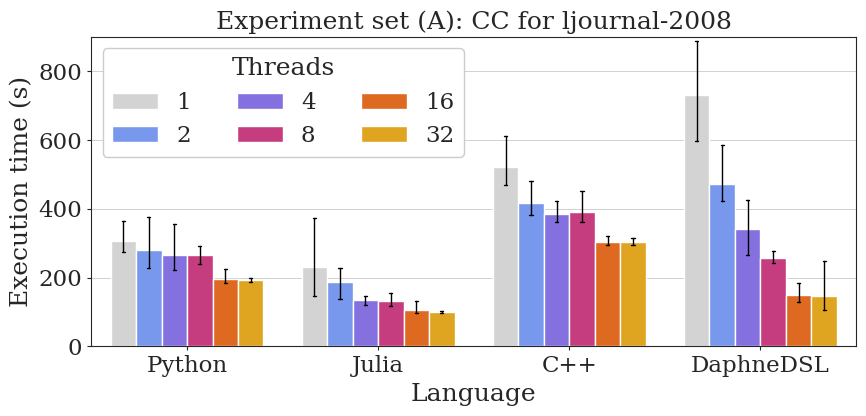

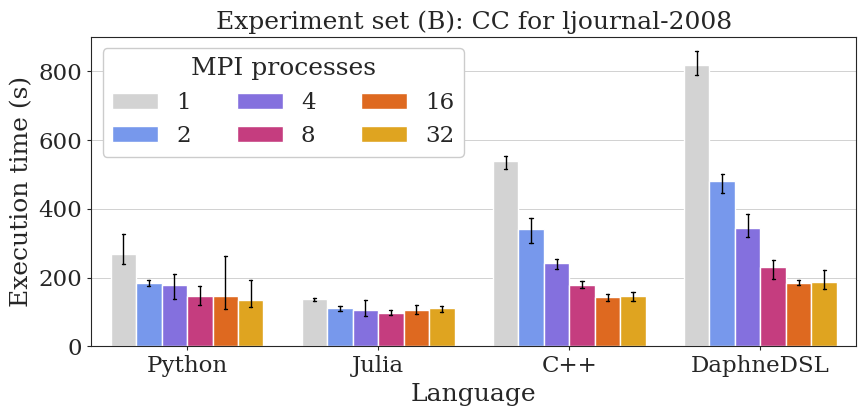

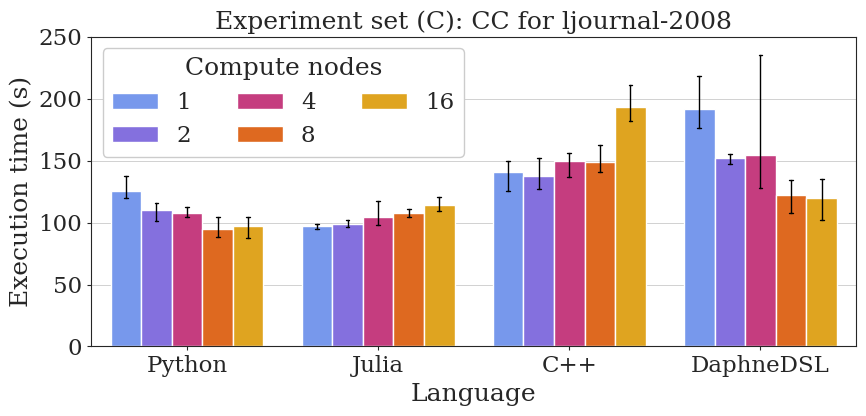

In [25]:
# output path for svg plots
path_svg = './performance/'

# plots are produced in loops

plot_loop = {
    'A_cc_ljournal' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'threads-per-process',
        'on_hue_label' : 'Threads',        
        'columns' : ['value', 'language', 'threads-per-process'],
        'filter_cols' : [
            ('threads-per-process', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', ['Connected Components']),
            ('language', ['Python', 'Julia', 'C++', 'DaphneDSL']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['Seq', '(A)']),
            ('matrix', ['ljournal-2008']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : 'Experiment set (A): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 900]
    },   
    'B_cc_ljournal' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'processes-per-node',
        'on_hue_label' : 'MPI processes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('processes-per-node', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', ['Connected Components']),
            ('language', ['Python', 'Julia', 'C++', 'DaphneDSL']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['(B)']),
            ('matrix', ['ljournal-2008']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : 'Experiment set (B): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 900]   
    },       
    'C_cc_ljournal' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'nodes',
        'on_hue_label' : 'Compute nodes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('nodes', [1,2,4,8,16]),  # hue filter list
            ('benchmark', ['Connected Components']),
            ('language', ['Python', 'Julia', 'C++', 'DaphneDSL']), # needed for ordering 
            ('type', ['(C)']),
            ('matrix', ['ljournal-2008']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : 'Experiment set (C): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 250]   
    }, 
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = [t[1] for t in v.get('filter_cols') if t[0] == on_x][0]  # x order from filter_cols
    hue_order = [t[1] for t in v.get('filter_cols') if t[0] == on_hue][0] if on_hue is not None else None  # hue order from filter_cols

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # # search order as defined in plot loop
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    # x_order = tuple_[1]
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    # hue_order = tuple_[1]

    # print(df)
    # print(data)
    # sys.exit(0)

    if data[on_hue].nunique() <= 5:
        palette_ = custom_palette[:data[on_hue].nunique()]
    else:
        palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=ncol)
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

## Performance Plots N-Body
<a id='perf_nbody'></a>

Used to create the plots for the coding productivity metrics:
* Sequential (Seq)
* Local parallel with threads (A)
* Local parallel with MPI processes (B)
* Distributed bt scaling nodes (C)

### Load results and check for completeness

## Python 3.14 no GIL tests
<a id='python'></a>

### Load results

In [ ]:
# load and read data
paths_results = [
    '../python-pre-experiments/results-py/',                     
]

# file name to text mapper
mapper = {
    'mp-imap': 'Mp\nIMap',
    'mp-map': 'Mp\nMap',
    'mp-imap-unordered': 'Mp\nIMap\nUnordered',
    'mp-threads': 'Mp\nThreads',
    'mpi4py': 'mpi4py',
    'numba': 'Numba',
    'omp4py-dynamic': 'omp4py\nDynamic',
    'omp4py-static': 'omp4py\nStatic',
    'omp4py-guided': 'omp4py\nGuided',
    'pyomp': 'PyOmp',
    'seq': 'Sequential\nPython',
    'numpy': 'NumPy',
    'threads': 'Thread-\ning',
    'py314t': 'Python v3.14 GIL-free',
    'py314': 'Python v3.14 GIL-bound',
    'py312': 'Python v3.12'
}

# all DAT files
all_files = []
for path in paths_results:
    all_files.extend(glob.glob(os.path.join(path, '*.txt'), recursive=True))

# read all DAT files and combine them into a single DataFrame
df_list = []

for filepath in all_files:
    
    parts = os.path.basename(filepath).split('_')

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(parts[0], pd.NA)
    pyV = mapper.get(parts[1], pd.NA)
    processes = int(parts[2].removeprefix('p'))
    threads = int(parts[3].removeprefix('t'))
    rep = int(parts[4].split('.')[0].removeprefix('r'))  # remove the .dat extension
    t_ete = 't-end-to-end'
    workers = processes * threads

    # dataframe column names
    col_names=['parallelFramework',
            'pythonVersion',
            'workers',
            'processes_ranks',
            'threads',
            'rep',
            'intervals',
            't-end-to-end',
            'checksum'
           ]
    
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        line = [l for l in lines if 'Time' in l][0]
        seconds = float(line.strip().split(' ')[3])
        line = [l for l in lines if 'Approximation' in l][0]
        intervals = int(line.strip().split(' ')[5].replace("'",''))
        result = float(line.strip().split(' ')[7])        
    except Exception as e:
        print(f"File {filepath}: empty line")
        continue

    # create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=col_names)
    # insert values into the first row (index 0)
    df.loc[0] = [
        algo,        # benchmark
        pyV,        # language    
        int(workers),
        int(processes),     
        int(threads),
        int(rep),
        int(intervals),
        float(seconds),
        float(result)
    ]
    
    df_list.append(df)                    

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['parallelFramework', 'pythonVersion', 'workers', 'processes_ranks', 'threads', 'rep','intervals','checksum'],  # keep these as identifiers
    value_vars=['t-end-to-end'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)    
#df_long['ParallelFramework'].unique()

,parallelFramework,pythonVersion,workers,processes_ranks,threads,rep,intervals,checksum,metric,value
0,Mp\nIMap\nUnordered,Python v3.14 GIL-free,1,1,1,2,500000000,3.141593,t-end-to-end,119.119388
1,omp4py\nGuided,Python v3.14 GIL-free,4,1,4,3,500000000,3.141593,t-end-to-end,21.943075
2,Sequential\nPython,Python v3.14 GIL-free,1,1,1,2,500000000,3.141593,t-end-to-end,89.527479
3,Mp\nIMap\nUnordered,Python v3.14 GIL-bound,1,1,1,5,500000000,3.141593,t-end-to-end,99.174728
4,Mp\nThreads,Python v3.14 GIL-free,4,1,4,3,500000000,3.141593,t-end-to-end,28.700434
5,NumPy,Python v3.14 GIL-bound,1,1,1,1,500000000,3.141593,t-end-to-end,10.485781
6,mpi4py,Python v3.14 GIL-bound,4,4,1,4,500000000,3.141593,t-end-to-end,22.757805
7,NumPy,Python v3.14 GIL-free,2,1,2,3,500000000,3.141593,t-end-to-end,11.230349
8,mpi4py,Python v3.14 GIL-free,4,4,1,1,500000000,3.141593,t-end-to-end,30.494916
9,Mp\nMap,Python v3.14 GIL-free,4,1,4,1,500000000,3.141593,t-end-to-end,31.992575


### Plots

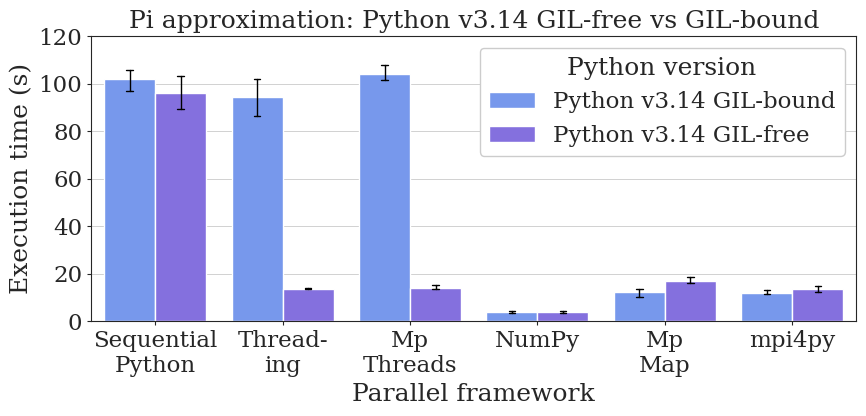

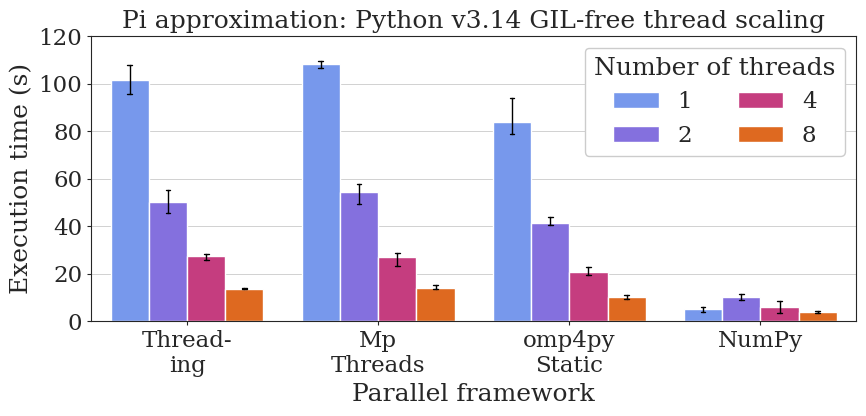

In [ ]:
# output path for svg plots
path_svg = './pre-experiments/'

# plots are produced in loops

plot_loop = {
    'py314_vs_py314t' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'parallelFramework',
        'on_x_label' : 'Parallel framework',
        'on_hue' : 'pythonVersion',
        'on_hue_label' : 'Python version',        
        'columns' : ['value', 'parallelFramework', 'pythonVersion'],
        'filter_cols' : [
            ('workers', [1,8]),
            ('metric', ['t-end-to-end']),
            ('pythonVersion', [ 'Python v3.14 GIL-bound','Python v3.14 GIL-free']),
            ('parallelFramework', ['Sequential\nPython', 'Thread-\ning', 'Mp\nThreads', 'NumPy', 'Mp\nMap' ,'mpi4py']),
        ],
        'filter_cols_conditional' : [ # set to None if not needed
            ('workers', [8]),
            ('parallelFramework', ['Sequential\nPython']),
        ],
        'title' : 'Pi approximation: Python v3.14 GIL-free vs GIL-bound',
        'loc' : 'upper right',   
        'ncol' : 1,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 120],
        'x_order' : ['Sequential\nPython', 'Thread-\ning', 'Mp\nThreads', 'NumPy', 'Mp\nMap' ,'mpi4py'],
        'hue_order' : ['Python v3.14 GIL-bound','Python v3.14 GIL-free'],
    },
    'py314t_scaling' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'parallelFramework',
        'on_x_label' : 'Parallel framework',
        'on_hue' : 'threads',
        'on_hue_label' : 'Number of threads',        
        'columns' : ['value', 'parallelFramework', 'pythonVersion'],
        'filter_cols' : [
            ('threads', [1,2,4,8]),
            ('metric', ['t-end-to-end']),
            ('pythonVersion', ['Python v3.14 GIL-free']),
            ('parallelFramework', ['Thread-\ning', 'Mp\nThreads', 'NumPy', 'omp4py\nStatic']),
        ],
        'filter_cols_conditional' : None, # set to None if not needed, or delete, same effect
        'title' : 'Pi approximation: Python v3.14 GIL-free thread scaling',
        'loc' : 'upper right',   
        'ncol' : 2,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 120],
        'x_order' : ['Thread-\ning', 'Mp\nThreads', 'omp4py\nStatic', 'NumPy'],
        'hue_order' : [1,2,4,8],
    }     
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = v.get('x_order')
    hue_order = v.get('hue_order')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # secondary filter cols
    if v.get('filter_cols_conditional', None) is not None:
        conditional = v.get('filter_cols_conditional')
        cond_mask = False
        for col, allowed in conditional:
            cond_mask |= df[col].isin(allowed)

        df = df[cond_mask]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # print(df)
    # print(data)
    # sys.exit(0)

    if data[on_hue].nunique() <= 5:
        palette_ = custom_palette[:data[on_hue].nunique()]
    else:
        palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=ncol)
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)